# Signal Purity Analysis
Analyze the purity of generated sine waves

In [134]:
import sys; print(sys.executable)

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# Configuration
sample_rate = 44100
duration = 20  # seconds
test_frequency = 100  # Hz
fade_seconds = 2

/home/cpu/git/study/.venv/bin/python


## Generate Signal

In [135]:
# Generate time array with exact integer sample count
num_samples = int(sample_rate * duration)
t = np.arange(num_samples, dtype=np.float64) / sample_rate

# Generate pure sine wave
phase = 2 * np.pi * test_frequency * t
wave = np.sin(phase)

# Scale to 80% amplitude to prevent clipping
wave *= 0.8

# Apply smooth fade using raised cosine (Hann window) instead of linear
# This is smoother and introduces less harmonic distortion
fade_samples = int(fade_seconds * sample_rate)
if fade_samples > 0:
    # Fade in: raised cosine (first half of Hann window)
    fade_in = 0.5 * (1 - np.cos(np.pi * np.arange(fade_samples) / fade_samples))
    wave[:fade_samples] *= fade_in
    
    # Fade out: raised cosine (second half of Hann window)
    fade_out = 0.5 * (1 + np.cos(np.pi * np.arange(fade_samples) / fade_samples))
    wave[-fade_samples:] *= fade_out

print(f"Generated {test_frequency} Hz sine wave")
print(f"Duration: {duration} s")
print(f"Sample rate: {sample_rate} Hz")
print(f"Total samples: {len(wave)}")
print(f"Max amplitude: {np.max(np.abs(wave)):.3f}")

Generated 100 Hz sine wave
Duration: 20 s
Sample rate: 44100 Hz
Total samples: 882000
Max amplitude: 0.800


## Time Domain Plot

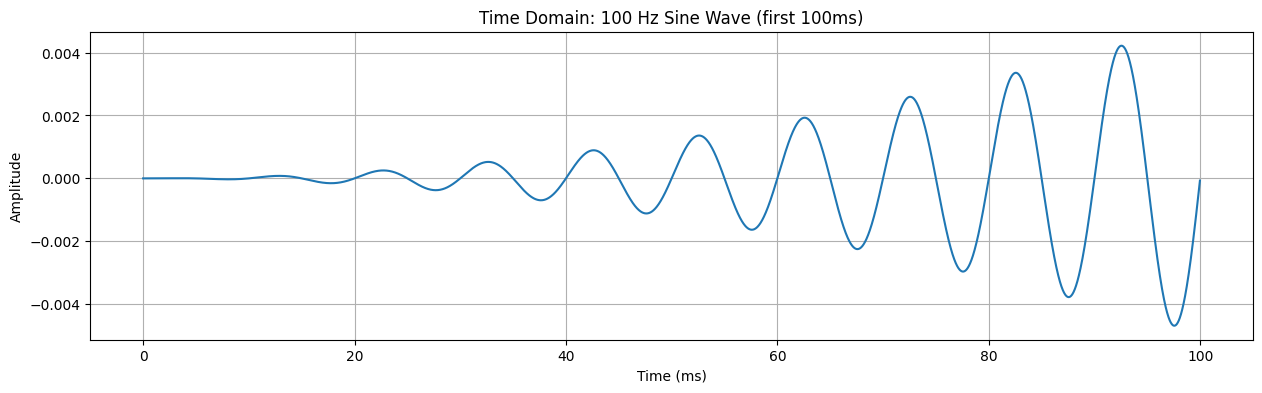

In [146]:
# Plot first 100ms of signal
plot_samples = int(0.1 * sample_rate)
plt.figure(figsize=(15, 4))
plt.plot(t[:plot_samples] * 1000, wave[:plot_samples])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title(f'Time Domain: {test_frequency} Hz Sine Wave (first 100ms)')
plt.grid(True)
plt.show()

## Frequency Spectrum (FFT)

In [117]:
# Calculate FFT (excluding fade regions for cleaner spectrum)
stable_start = fade_samples
stable_end = len(wave) - fade_samples
stable_wave = wave[stable_start:stable_end]
N = len(stable_wave)

# Apply window to reduce spectral leakage
window = np.hanning(N)
windowed_wave = stable_wave * window

# Compute FFT
yf = fft(windowed_wave)
xf = fftfreq(N, 1 / sample_rate)[:N//2]
magnitude = 2.0/N * np.abs(yf[:N//2])

# Convert to dB
magnitude_db = 20 * np.log10(magnitude + 1e-10)

print(f"FFT Resolution: {sample_rate/N:.3f} Hz")
print(f"Analyzed samples: {N} ({N/sample_rate:.2f} seconds)")

FFT Resolution: 0.062 Hz
Analyzed samples: 705600 (16.00 seconds)


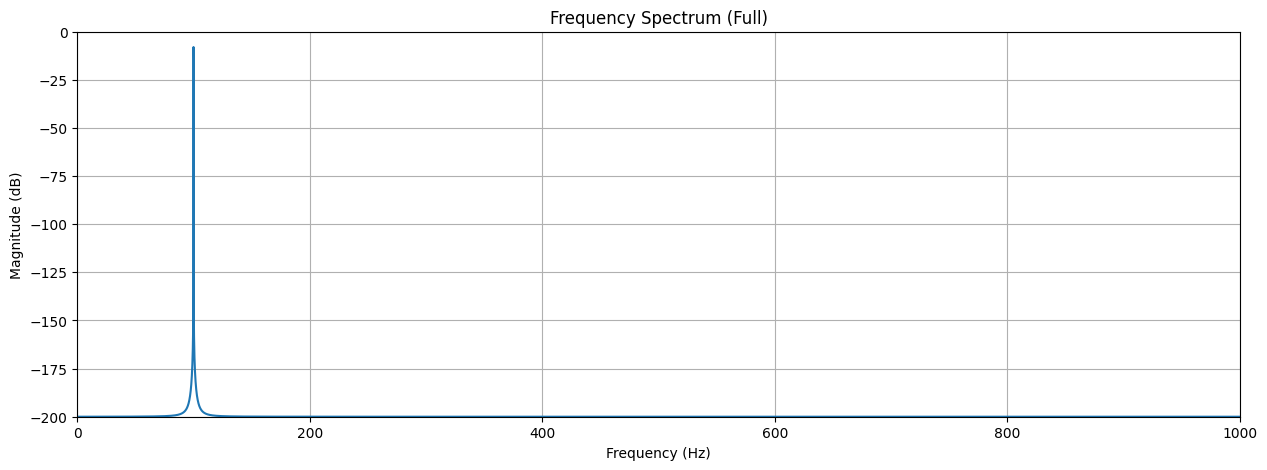

In [118]:
# Plot full spectrum
plt.figure(figsize=(15, 5))
plt.plot(xf, magnitude_db)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Spectrum (Full)')
plt.grid(True)
plt.xlim(0, 1000)
plt.ylim(-200, 0)
plt.show()

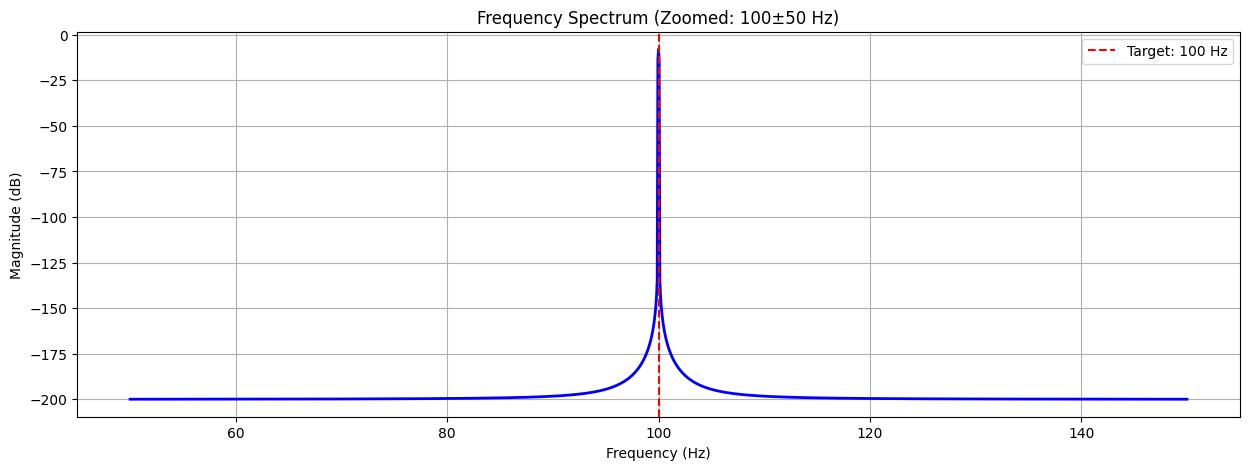

In [119]:
# Plot zoomed spectrum around fundamental frequency
zoom_range = 50  # Hz around target frequency
mask = (xf >= test_frequency - zoom_range) & (xf <= test_frequency + zoom_range)

plt.figure(figsize=(15, 5))
plt.plot(xf[mask], magnitude_db[mask], 'b-', linewidth=2)
plt.axvline(test_frequency, color='r', linestyle='--', label=f'Target: {test_frequency} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title(f'Frequency Spectrum (Zoomed: {test_frequency}±{zoom_range} Hz)')
plt.grid(True)
plt.legend()
plt.show()

## Harmonic Analysis

In [120]:
# Find peak frequency
peak_idx = np.argmax(magnitude)
peak_freq = xf[peak_idx]
peak_mag = magnitude_db[peak_idx]

print(f"Peak frequency: {peak_freq:.2f} Hz")
print(f"Peak magnitude: {peak_mag:.2f} dB")
print(f"Frequency error: {peak_freq - test_frequency:.3f} Hz")
print()

# Find harmonics (2f, 3f, 4f, 5f)
print("Harmonics:")
for harmonic in range(2, 6):
    harmonic_freq = test_frequency * harmonic
    if harmonic_freq < sample_rate / 2:  # Nyquist limit
        # Find magnitude near harmonic frequency
        harm_mask = (xf >= harmonic_freq - 5) & (xf <= harmonic_freq + 5)
        if np.any(harm_mask):
            harm_mag = np.max(magnitude_db[harm_mask])
            harm_rel = harm_mag - peak_mag
            print(f"  {harmonic}f ({harmonic_freq:.0f} Hz): {harm_mag:.2f} dB ({harm_rel:+.2f} dB relative)")

Peak frequency: 100.00 Hz
Peak magnitude: -7.96 dB
Frequency error: 0.000 Hz

Harmonics:
  2f (200 Hz): -199.98 dB (-192.02 dB relative)
  3f (300 Hz): -200.00 dB (-192.04 dB relative)
  4f (400 Hz): -200.00 dB (-192.04 dB relative)
  5f (500 Hz): -200.00 dB (-192.04 dB relative)


## Spectrogram

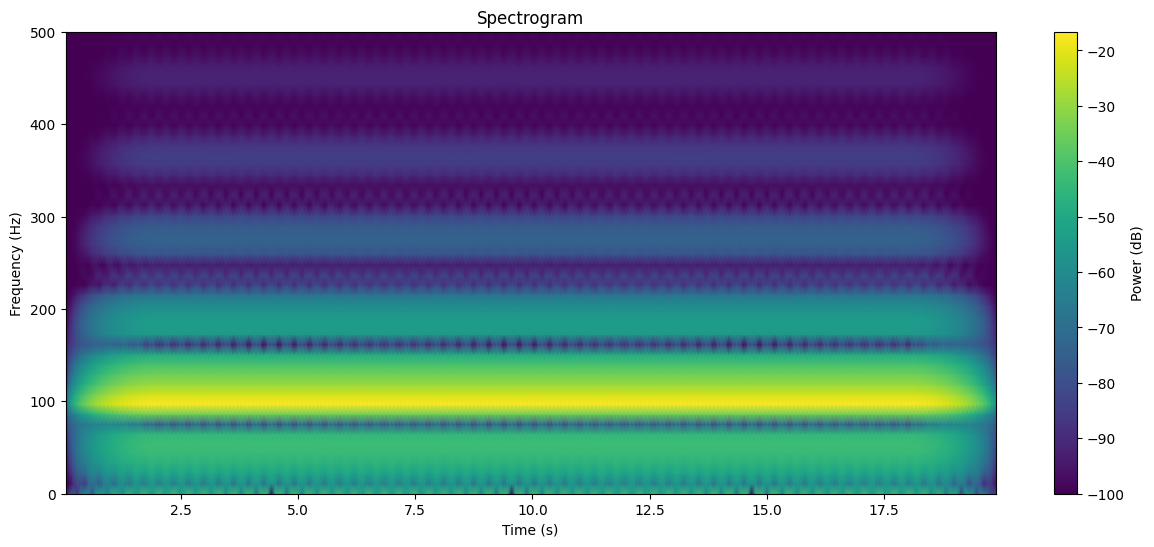

In [121]:
# Compute spectrogram
f, t_spec, Sxx = signal.spectrogram(wave, sample_rate, nperseg=4096)

plt.figure(figsize=(15, 6))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram')
plt.colorbar(label='Power (dB)')
plt.ylim(0, 500)
plt.show()

## THD (Total Harmonic Distortion) Calculation

In [122]:
# Calculate THD
fundamental_power = magnitude[peak_idx]**2
harmonic_power_sum = 0

for harmonic in range(2, 11):  # Check up to 10th harmonic
    harmonic_freq = test_frequency * harmonic
    if harmonic_freq < sample_rate / 2:
        harm_mask = (xf >= harmonic_freq - 2) & (xf <= harmonic_freq + 2)
        if np.any(harm_mask):
            harm_power = np.max(magnitude[harm_mask])**2
            harmonic_power_sum += harm_power

thd = np.sqrt(harmonic_power_sum / fundamental_power) * 100
print(f"Total Harmonic Distortion (THD): {thd:.4f}%")

if thd < 0.1:
    print("Signal quality: EXCELLENT (THD < 0.1%)")
elif thd < 1:
    print("Signal quality: GOOD (THD < 1%)")
elif thd < 5:
    print("Signal quality: ACCEPTABLE (THD < 5%)")
else:
    print("Signal quality: POOR (THD >= 5%)")

Total Harmonic Distortion (THD): 0.0000%
Signal quality: EXCELLENT (THD < 0.1%)


## Export Signal (Optional)

In [123]:
from scipy.io import wavfile
wavfile.write(f'test_signal_{test_frequency}Hz.wav', sample_rate, (wave * 32767).astype(np.int16))
print(f"Signal saved to test_signal_{test_frequency}Hz.wav")

Signal saved to test_signal_100Hz.wav
